# GPU & Module

In [30]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

from scipy.io import loadmat

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import time
import datetime

# Data Import

## Load Data

In [2]:
def load_mat_case_ABCD(files, key = 'Channel_1'):
    A,B,C,D = [], [], [], []
    for i in files:
        mat = loadmat(i)
        if i.find('-A-')>0:
            A.append({'name': os.path.basename(i), key : mat[key]})
        elif i.find('-B-')>0:
            B.append({'name': os.path.basename(i), key : mat[key]})
        elif i.find('-C-')>0:
            C.append({'name': os.path.basename(i), key : mat[key]})
        elif i.find('-D-')>0:
            D.append({'name': os.path.basename(i), key : mat[key]})    
    return A, B, C, D

In [46]:
data_dir = './resized_stft_seg/'

healthy_mat_files = glob.glob(data_dir + 'Healthy' + '/*.mat')
inner_fault_mat_files = glob.glob(data_dir + 'Inner Fault' + '/*.mat')
outer_fault_mat_files = glob.glob(data_dir + 'Outer Fault' + '/*.mat')

healthy_As, healthy_Bs, healthy_Cs, healthy_Ds = load_mat_case_ABCD(healthy_mat_files, key = 'resized_segments')
inner_fault_As, inner_fault_Bs, inner_fault_Cs, inner_fault_Ds = load_mat_case_ABCD(inner_fault_mat_files, key = 'resized_segments')
outer_fault_As, outer_fault_Bs, outer_fault_Cs, outer_fault_Ds = load_mat_case_ABCD(outer_fault_mat_files, key = 'resized_segments')

In [47]:
def one_hot(data, classes, nb_classes = 2):
    one_hot = [0]*nb_classes
    one_hot[classes] = 1
    return np.vstack([one_hot for i in range(len(data))])

In [48]:
H_A_x = np.vstack([healthy_As[i]['resized_segments'] for i in range(3)]).reshape(-1, 256, 256 ,1)
I_A_x = np.vstack([inner_fault_As[i]['resized_segments'] for i in range(3)]).reshape(-1, 256, 256 ,1)
O_A_x = np.vstack([outer_fault_As[i]['resized_segments'] for i in range(3)]).reshape(-1, 256, 256 ,1)

H_A_y = one_hot(H_A_x, 0, nb_classes = 3)
I_A_y = one_hot(I_A_x, 1, nb_classes = 3)
O_A_y = one_hot(O_A_x, 2, nb_classes = 3)

print("Healthy for A:", H_A_x.shape, H_A_y.shape)
print("Inner fault for A:", I_A_x.shape, I_A_y.shape)
print("Outer fault for A:", O_A_x.shape, O_A_y.shape)

Healthy for A: (150, 256, 256, 1) (150, 3)
Inner fault for A: (150, 256, 256, 1) (150, 3)
Outer fault for A: (150, 256, 256, 1) (150, 3)


## Training/Validation split

In [25]:
def train_valid_split(data, label, train_rate = 0.8):
    train_idx = np.sort(np.random.choice(len(data), round(len(data)*train_rate), replace = False))
    valid_idx = np.setxor1d(train_idx, np.arange(len(data)))
    return data[train_idx], label[train_idx], data[valid_idx], label[valid_idx]

In [26]:
H_A_train_x, H_A_train_y, H_A_valid_x, H_A_valid_y = train_valid_split(H_A_x, H_A_y)
I_A_train_x, I_A_train_y, I_A_valid_x, I_A_valid_y = train_valid_split(I_A_x, I_A_y)
O_A_train_x, O_A_train_y, O_A_valid_x, O_A_valid_y = train_valid_split(O_A_x, O_A_y)

print("Healthy for A:", H_A_train_x.shape, H_A_train_y.shape, H_A_valid_x.shape, H_A_valid_y.shape)
print("Inner fault for A:", I_A_train_x.shape, I_A_train_y.shape, I_A_valid_x.shape, I_A_valid_y.shape)
print("Outer fault for A:", O_A_train_x.shape, O_A_train_y.shape, O_A_valid_x.shape, O_A_valid_y.shape)

Healthy for A: (120, 256, 256, 1) (120, 3) (30, 256, 256, 1) (30, 3)
Inner fault for A: (120, 256, 256, 1) (120, 3) (30, 256, 256, 1) (30, 3)
Outer fault for A: (120, 256, 256, 1) (120, 3) (30, 256, 256, 1) (30, 3)


In [36]:
train_X = np.vstack([H_A_train_x, I_A_train_x, O_A_train_x])
train_Y = np.vstack([H_A_train_y, I_A_train_y, O_A_train_y])
valid_X = np.vstack([H_A_valid_x, I_A_valid_x, O_A_valid_x])
valid_Y = np.vstack([H_A_valid_y, I_A_valid_y, O_A_valid_y])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (360, 256, 256, 1) (360, 3)
Validation set: (90, 256, 256, 1) (90, 3)


# Model

In [28]:
input_h = 256
input_w = 256
input_ch = 1

k1_ch = 16
# 128 128 16

k2_ch = 16
# 64 64 16

k3_ch = 32
# 32 32 32

k4_ch = 32
# 16 16 32

k5_ch = 32
# 8 8 32

k6_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 3

In [32]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')

def CNN_block(x, k_channel, maxp_name = 'maxp'):
    conv1 = tf.layers.conv2d(inputs = x, 
                             filters = k_channel, 
                             kernel_size = [3, 3], 
                             padding = "SAME",
                             activation= tf.nn.relu)
    conv2 = tf.layers.conv2d(inputs = conv1, 
                             filters = k_channel, 
                             kernel_size = [3, 3], 
                             padding = "SAME",
                             activation= tf.nn.relu)
    maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                   pool_size = [2, 2], 
                                   strides = 2,
                                   name = maxp_name)
    return maxp

def FC2_layer(x, n_hidden1, n_hidden2, score_name = 'score'):
    maxp_re = tf.layers.flatten(x)
    hidden1 = tf.layers.dense(inputs = maxp_re, 
                              units = n_hidden1,
                              activation = tf.nn.relu)
    hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
    hidden2 = tf.layers.dense(inputs = hidden1, 
                              units = n_hidden2,
                              activation = tf.nn.relu)
    hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
    score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
    return score


def NET(x):
    conv1 = CNN_block(x, k1_ch, 'maxp1')
    conv2 = CNN_block(conv1, k2_ch, 'maxp2')
    conv3 = CNN_block(conv2, k3_ch, 'maxp3')
    conv4 = CNN_block(conv3, k4_ch, 'maxp4')
    conv5 = CNN_block(conv4, k5_ch, 'maxp5')
    conv6 = CNN_block(conv5, k6_ch, 'maxp6')
    
    score = FC2_layer(conv6, n_hidden1, n_hidden2, 'score')

    return score

score = NET(x)

# loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=score)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1201 23:28:33.265618 140098228352768 deprecation.py:323] From <ipython-input-32-985a708b5ac9>:26: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W1201 23:28:33.449352 140098228352768 deprecation.py:323] From <ipython-input-32-985a708b5ac9>:29: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1201 23:28:33.683027 140098228352768 deprecation.py:323] From <ipython-input-32-985a708b5ac9>:30: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W1201 23:28:33.878734 140098228352768 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_o

# Training

In [37]:
class Contents:
    def table(self):
        print('==============================================================')
        print('[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss')
        print('==============================================================')
    def evl(self):
        evl = '[{0:*>4d}] || {1:*>.2f} %    || {2:*>.2f} %    || {3:.8f} || {4:.8f}'.format(n_iter, 
                                                                                      accr_train[-1]*100, accr_valid[-1]*100, 
                                                                                      loss_train[-1], loss_valid[-1])
        return evl
    def prt_evl(self):
        print(self.evl())
        print('--------------------------------------------------------------')
    def early_under(self):
        print(self.evl() + ' [Early stopping - Underffiting !!]\n')
    def early_over(self):
        print(self.evl() + ' [Early stopping - Overffiting !!]\n')
    def early(self):
        print(self.evl() + ' [Early stopping]\n')
    def done(self):  
        global training_name
        global contents
        global filename
        global title
        
        now = datetime.datetime.now()
        nowDatetime = now.strftime('%y%m%d%H%M')
        
        training_name = 'H_{}'.format(nowDatetime)
        
        contents = (
        'Training Time : {} Min.\n'.format(train_time) +
        'Early Stopping : {}\n'.format(early_stopping) +
        'Iteration : {}\n'.format(n_iter)
        )
        print(contents)

        filename = training_name + '.png'
        title = '[iAI_Server] Training Report - {}'.format(training_name)

In [38]:
def random_minibatch(x, y, batch_size = 50):
    idx = np.random.choice(len(x), batch_size)
    return x[idx], y[idx]

def shuffle(x, y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    if type(x) == type(y):
        return x[idx], y[idx] 
    else:
        return x[idx]
    
def history(save = True):
    fig = plt.figure(figsize = (15,20))
    plt.suptitle('Training History', y = 0.92, fontsize = 20)
    
    x_axis = range(1, len(accr_train)+1)
    
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, accr_train, 'b-', label = 'Training Accuracy')
    plt.plot(x_axis, accr_valid, 'r-', label = 'Validation Accuracy')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.subplot(2, 1, 2)
    plt.plot(x_axis, loss_train, 'b-', label = 'Training Loss')
    plt.plot(x_axis, loss_valid, 'r-', label = 'Validation Loss')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
#     plt.yticks(np.arange(0, 0.25, step=0.025))
    plt.legend(fontsize = 12)
    plt.show()
    if save == True:
        fig.savefig(hist_path + filename)
        plt.close(fig)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 100.00 %    || 100.00 %    || 0.16948032 || 0.14064549
--------------------------------------------------------------
[*200] || 100.00 %    || 100.00 %    || 0.00015487 || 0.00019499
--------------------------------------------------------------
[*300] || 100.00 %    || 100.00 %    || 0.00040344 || 0.00033469
--------------------------------------------------------------
[*400] || 100.00 %    || 100.00 %    || 0.00002634 || 0.00003028
--------------------------------------------------------------
[*500] || 100.00 %    || 100.00 %    || 0.00000122 || 0.00000072
--------------------------------------------------------------
[*600] || 100.00 %    || 100.00 %    || 0.00000122 || 0.00000193
--------------------------------------------------------------
[*700] || 100.00 %    || 100.00 %    || 0.00000220 || 0.00000188
--------------------------------------------------------------
[*800] || 100.00 %    || 100.00 %    || 0

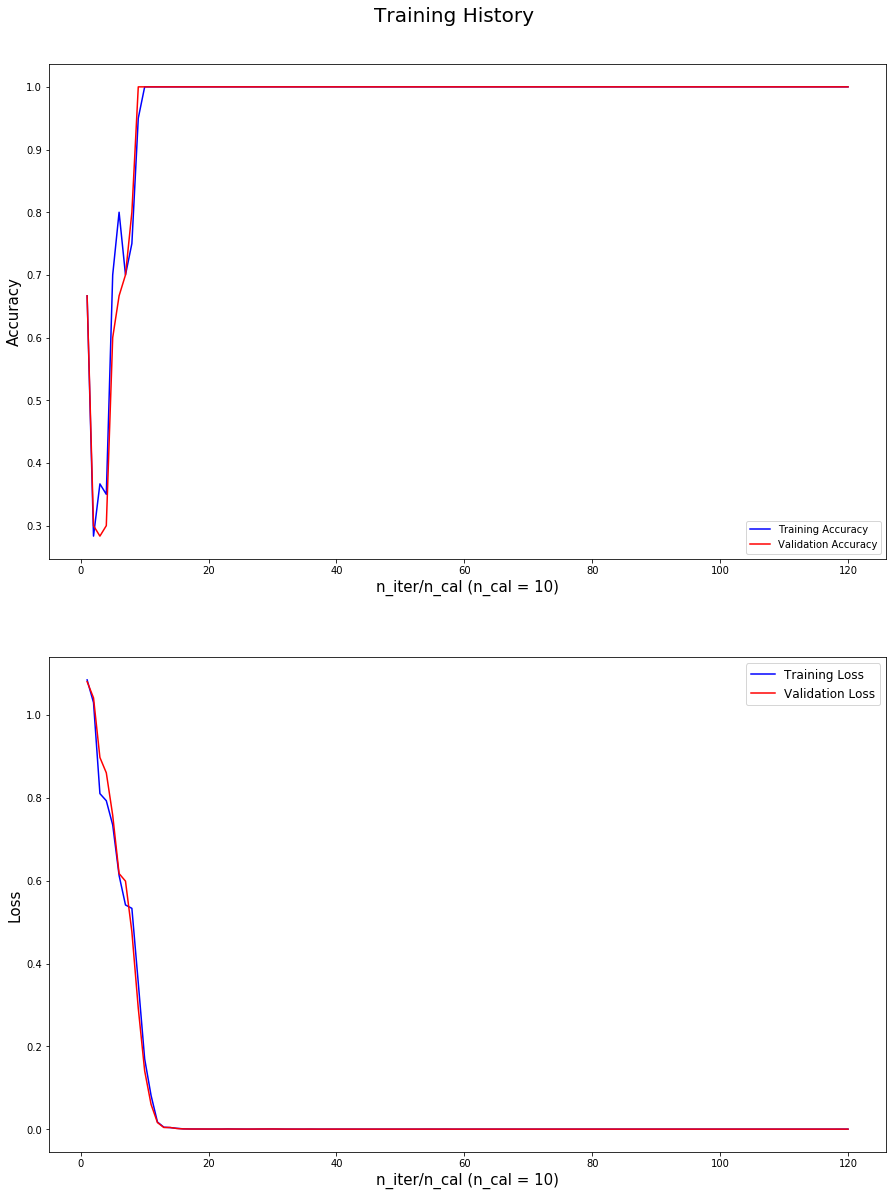

In [45]:
n_batch = 60
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)

lr = 1e-4
optm = tf.train.AdamOptimizer(lr).minimize(loss)

con = Contents()

accr_valid = []
loss_valid = []
accr_train = []
loss_train = []

early_stopping = False

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

con.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = n_batch)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0':1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0':0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = n_batch)
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0':0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            con.prt_evl()
            
        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'stft_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/stft/' + model_name)
        if n_iter > 1000:
            if np.max(accr_train) < 0.9:
                if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
                    con.early_under()
                    early_stopping = True
                    break
            if np.mean(accr_train[-50:]) >= 0.995:
                if (
                    np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
                    loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
                    ):
                    con.early_over()
                    early_stopping = True
                    break          

train_time = int((time.time() - start_time)/60)  
con.done()

history(save = False)   

# sess.close()